In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


dataset/2.csv
dataset/1.csv
dataset/0.csv
dataset/3.csv


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from mne.filter import filter_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
from functools import partial
import tempfile
from pathlib import Path

In [4]:
# Four classes of motion were written from MYO armband with the help of our app https://github.com/cyber-punk-me/nukleos.
# The MYO armband has 8 sensors placed on skin surface, each measures electrical activity produced by muscles beneath.

# Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. 
# The last column is a resulting gesture that was made while recording the data (classes 0-3)
# So each line has the following structure:
# [8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]
# Data was recorded at 200 Hz, which means that each line is 8*(1/200) seconds = 40ms of record time.

# A classifier given 64 numbers would predict a gesture class (0-3).
# Gesture classes were : rock - 0, scissors - 1, paper - 2, ok - 3. 
# Rock, paper, scissors gestures are like in the game with the same name, and OK sign is index finger touching the thumb and the rest of the fingers spread. 
# Each gesture was recorded 6 times for 20 seconds. Each time recording started with the gesture being already prepared and held. 
# Recording stopped while the gesture was still being held. In total there is 120 seconds of each gesture being held in fixed position. 
# All of them recorded from the same right forearm in a short timespan. 
# Every recording of a certain gesture class was concatenated into a .csv file with a corresponding name (0-3).

df0 = pd.read_csv("dataset/0.csv", header=None)
print("Class 0 Shape", df0.shape)
df1 = pd.read_csv("dataset/1.csv", header=None)
print("Class 1 Shape", df1.shape)
df2 = pd.read_csv("dataset/2.csv", header=None)
print("Class 2 Shape", df2.shape)
df3 = pd.read_csv("dataset/3.csv", header=None)
print("Class 3 Shape", df3.shape)

df = pd.concat([df0,df1,df2,df3])
print("Combined Shape", df.shape)
data = df.values
# data_shape = data.shape
# print(data.shape)

# raw_sf = 200
# bandpass_freqs = [1, 64]
# data = filter_data(
#         np.squeeze(data).astype("float64"),
#         raw_sf,
#         bandpass_freqs[0],
#         bandpass_freqs[1],
#         verbose=0,
# )
# data.reshape(data_shape)
# print(data.shape)

# sc = RobustScaler()
sc = MinMaxScaler(feature_range = (0, 1))

Class 0 Shape (2910, 65)
Class 1 Shape (2903, 65)
Class 2 Shape (2943, 65)
Class 3 Shape (2922, 65)
Combined Shape (11678, 65)


(23280, 4)
(11678, 65)


/tmp/ipykernel_157950/2178716975.py:12: RuntimeWarning: filter_length (661) is longer than the signal (64), distortion is likely. Reduce filter length or filter a longer signal.
  data[:,:-1] = filter_data(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:   

(23280, 4)


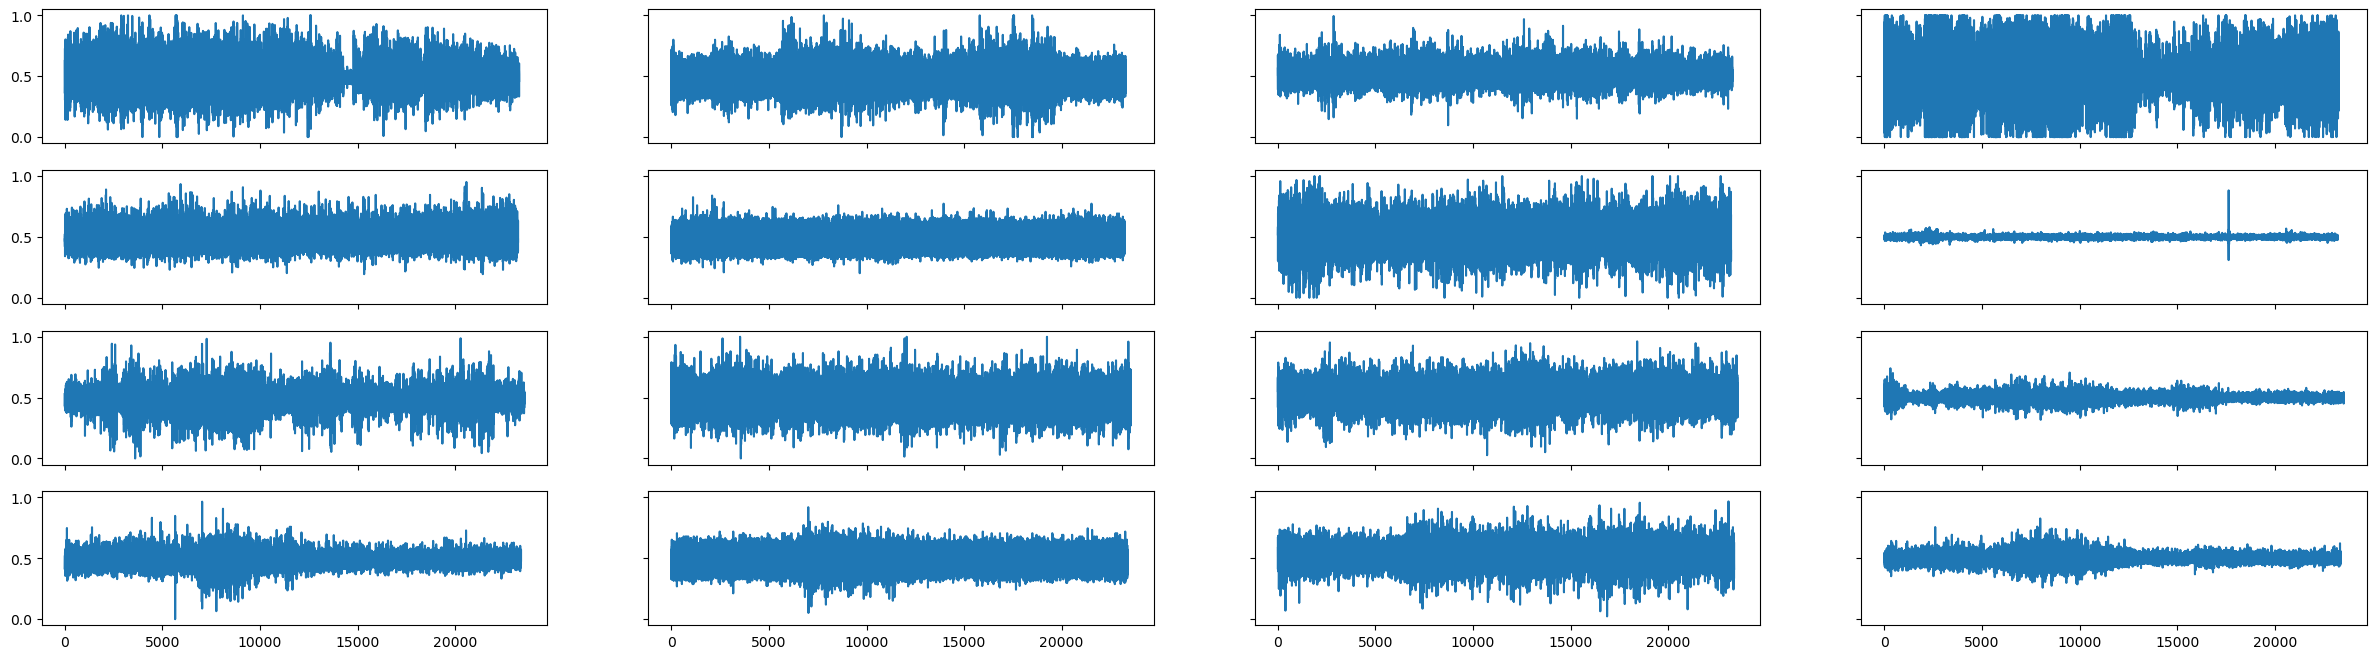

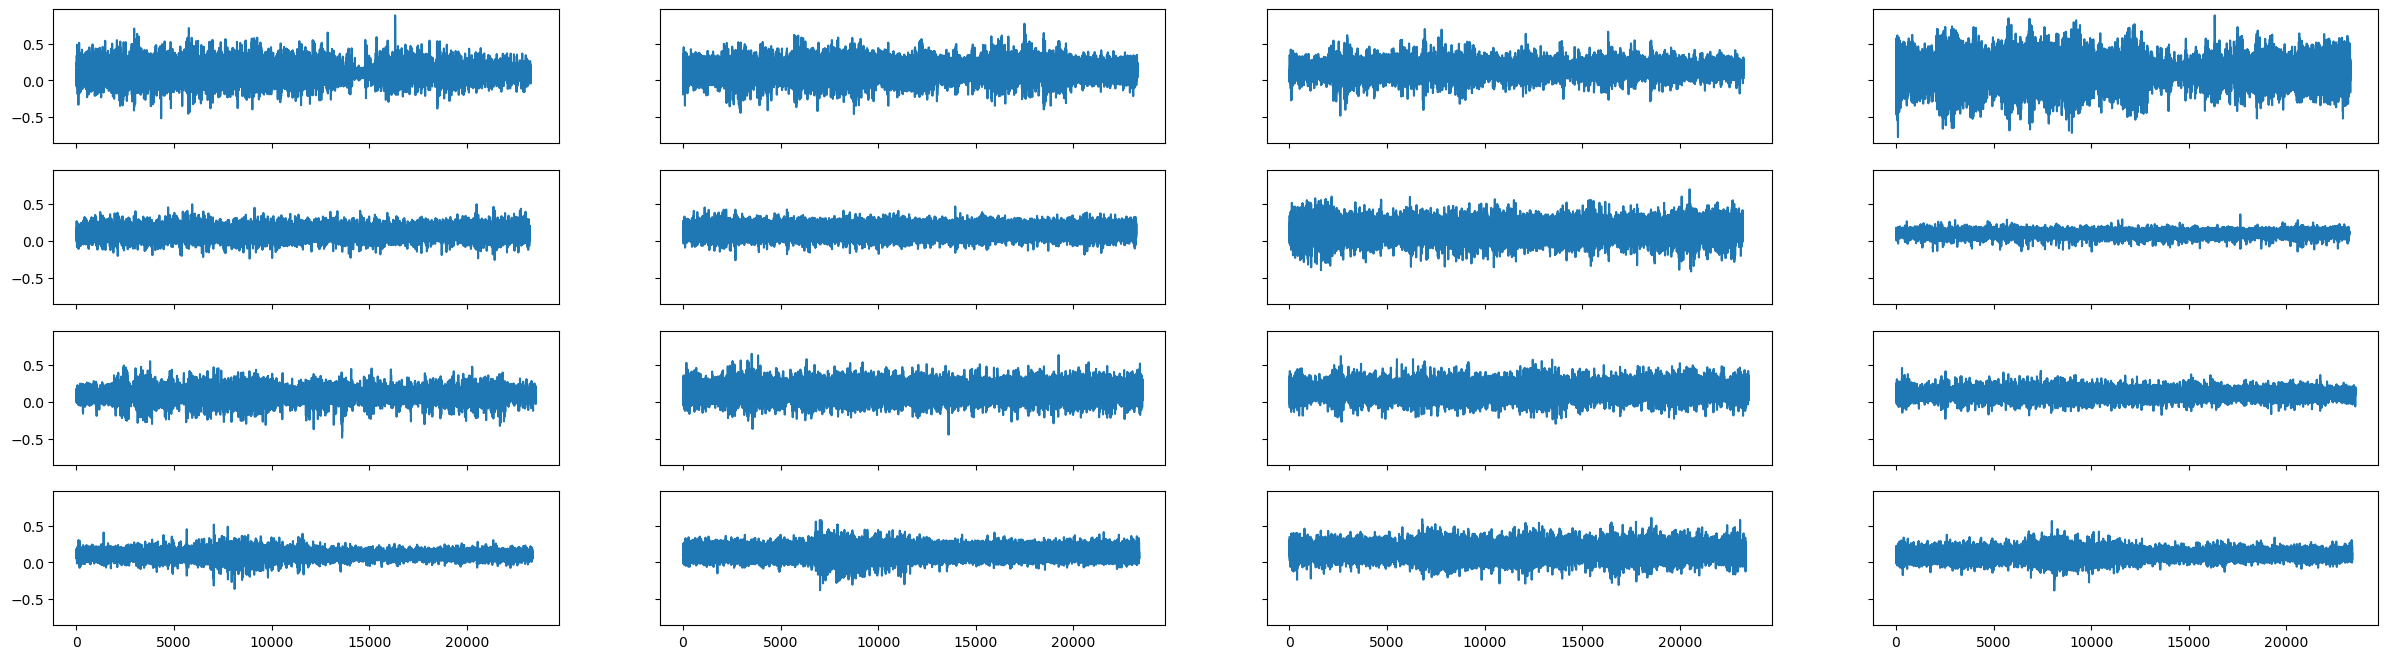

In [5]:
def plot_data(data, filtered=False):
    
    X0, X1, X2, X3=[],[],[],[]
    data[:,:-1] = sc.fit_transform(data[:,:-1])

    if filtered:
        data_shape = data[:,:-1].shape
        print(data.shape)

        raw_sf = 200
        bandpass_freqs = [1, 64]
        data[:,:-1] = filter_data(
            np.squeeze(data[:,:-1]).astype("float64"),
            raw_sf,
            bandpass_freqs[0],
            bandpass_freqs[1],
            verbose=0,
        )
        data[:,:-1].reshape(data_shape)
    
    for i in range(data.shape[0]):
        tmp = data[i,:-1].reshape((8,8))
        # Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. 
        # The last column is a resulting gesture that was made while recording the data (classes 0-3) 
        # So each line has the following structure:
        # [8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]
        for j in range(8):
            
            if data[i,-1] == 0:
                X0.append([tmp[j][s] for s in range(0, 8, 2)])
            
            elif data[i,-1] == 1:
                X1.append([tmp[j][s] for s in range(0, 8, 2)])
            
            elif data[i,-1] == 2:
                X2.append([tmp[j][s] for s in range(0, 8, 2)])
                # X2.append(tmp[j,:])

            elif data[i,-1] == 3:
                X3.append([tmp[j][s] for s in range(0, 8, 2)])
                # X3.append(tmp[j,:])
    
    X0, X1, X2, X3 = np.array(X0), np.array(X1), np.array(X2), np.array(X3)    
    print(X0.shape)
        
    fig, axes = plt.subplots(4,4, figsize=(30, 8), sharex=True, sharey=True)
    # for i in range(8):
    for i in range(4):
        axes[0][i].plot(X0[:,i], label='Raw Ch '+str(i))
        axes[1][i].plot(X1[:,i], label='Raw Ch '+str(i))
        axes[2][i].plot(X2[:,i], label='Raw Ch '+str(i))
        axes[3][i].plot(X3[:,i], label='Raw Ch '+str(i))
        
# vertical axis defines the EMG signal amplitude, and the horizontal axis defines the time.
# Vertical arrangement of the plots represents the 4 classes of gestures.
# Horizontal arrangement of the plots represents the (trimmed 8) 4 channels of EMG data.
plot_data(data)
plot_data(data, filtered=True)

In [6]:
class PureLSTM(nn.Module):
    
    # we can optimize hidden units, sequence length, number of layers, and hidden features
    def __init__(self, n_features=4, n_hidden=16, n_sequence=8, n_layers=1, n_classes=4, hidden_features=128, dropout0=False):
        super(PureLSTM, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_sequence = n_sequence
        self.n_layers = n_layers
        self.n_classes = n_classes
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        self.dropout0 = None
        if dropout0:
            self.dropout0 = nn.Dropout(p=0.2)
        self.linear_1 = nn.Linear(in_features=n_hidden, out_features=hidden_features)
        self.dropout_1 = nn.Dropout(p=0.2)
        
        self.linear_2 = nn.Linear(in_features=hidden_features, out_features=n_classes)        
        
    
    def forward(self, x):
        self.hidden = (
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device),
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device)
        )
    
        out, (hs, cs) = self.lstm(x.view(len(x), self.n_sequence, -1),self.hidden)
        out = out[:,-1,:]
        if self.dropout0:
            out = self.dropout0(out)
        out = self.linear_1(out)
        out = self.dropout_1(out)
        out = self.linear_2(out)
        
        return out
    
def train_model(model, train_dataloader, n_epochs=200, lr=0.01):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr) # was 0.001
    
    for epoch in range(n_epochs):

        for i, (X_train, y_train) in enumerate(train_dataloader):
            
            y_hat = model(X_train)
            
            loss = loss_fn(y_hat.float(), y_train)

            if i == 0 and (epoch+1)%10==0:
                print(f'Epoch {epoch+1} train loss: {loss.item()}')

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        
    return model

In [7]:
def select_4_channels(data):
    X = []
    for i in range(data.shape[0]):
        tmp = data[i]
        for j in range(8):
            X.append([tmp[j][s] for s in range(0, 8, 2)])
    return np.array(X).reshape(-1,8,4)

def prepare_data(data, filtered=False):
    data[:,:-1] = sc.fit_transform(data[:,:-1])
    np.random.shuffle(data)
    if filtered:
        data_shape = data[:,:-1].shape
        raw_sf = 200
        bandpass_freqs = [1, 64]
        data[:,:-1] = filter_data(
            np.squeeze(data[:,:-1]).astype("float64"),
            raw_sf,
            bandpass_freqs[0],
            bandpass_freqs[1],
            verbose=0,
        )
        data[:,:-1].reshape(data_shape)
    X, y = data[:,:-1], data[:,-1]
    X = X.reshape(-1,8,8)
    X = select_4_channels(X)
    print("X prepared shape", X.shape)
    
    X_train = torch.from_numpy(X[:7700])
    y_train = torch.from_numpy(y[:7700])
    X_test = torch.from_numpy(X[7700:])
    y_test = torch.from_numpy(y[7700:])
    
    return X_train.float().to(device), y_train.long().to(device), X_test.float().to(device), y_test.long().to(device)

In [8]:
class EmgDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    
    
# n_features=4
# n_sequence=8
# n_hidden=16
# n_layers=2
# n_classes=4

# n_epochs = 400
# n_batch_size = 256

# model = PureLSTM(n_features, n_hidden, n_sequence, n_layers, n_classes).to(device)
# X_train, y_train, X_test, y_test = prepare_data(data, n_sequence)

# print("Train Data Shape ",X_train.shape, y_train.shape)
# print("Test Data Shape ",X_test.shape, y_test.shape)

# train_dataset = EmgDataset(X_train, y_train)
# train_dataloader = DataLoader(dataset = train_dataset, batch_size=n_batch_size, shuffle=True)
# model = train_model(model, train_dataloader, n_epochs = n_epochs)

In [9]:
def train_hyper(config, data_dir=None):
    n_features=4
    n_classes=4
    n_sequence=8
    n_hidden=config['n_hidden']
    n_layers=config['n_layers']

    n_epochs = config['n_epochs']
    n_batch_size = config['n_batch_size']

    model = PureLSTM(n_features, n_hidden, n_sequence, n_layers, n_classes).to(device)

    X_train, y_train, X_test, y_test = prepare_data(data, config['filtered'])

    print("Train Data Shape ",X_train.shape, y_train.shape)
    print("Test Data Shape ",X_test.shape, y_test.shape)

    train_dataset = EmgDataset(X_train, y_train)
    train_dataloader = DataLoader(dataset = train_dataset, batch_size=n_batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), config['lr']) # was 0.001
    
    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    for epoch in range(n_epochs):
        for i, (X_train, y_train) in enumerate(train_dataloader):
            y_hat = model(X_train)
            
            loss = loss_fn(y_hat.float(), y_train)

            if i == 0 and (epoch+1)%10==0:
                print(f'Epoch {epoch+1} train loss: {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        y_hat_train = model(X_train)
        prediction = torch.argmax(y_hat_train, dim=1)
        good = 0
        for i in range(len(y_train)):
            if (prediction[i] == y_train[i]):
                good = good +1
        acc = (good/len(y_train)) * 100.0
        print("Train Accuracy ", acc)

        y_hat_test = model(X_test)
        prediction = torch.argmax(y_hat_test, dim=1)
        good = 0
        for i in range(len(y_test)):
            if (prediction[i] == y_test[i]):
                good = good +1
        acc = (good/len(y_test)) * 100.0
        print("Test Accuracy ", acc)
    
    checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
    with tempfile.TemporaryDirectory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "wb") as fp:
            pickle.dump(checkpoint_data, fp)
        checkpoint = Checkpoint.from_directory(checkpoint_dir)
        train.report(
            {"accuracy": acc},
            checkpoint=checkpoint,
        )


In [10]:
def evaluateModel(prediction, y):
    prediction = torch.argmax(prediction, dim=1)
    good = 0
    for i in range(len(y)):
        if (prediction[i] == y[i]):
            good = good +1
    return (good/len(y)) * 100.0


# with torch.no_grad():
#     y_hat_train = model(X_train)
#     print("Train Accuracy ", evaluateModel(y_hat_train, y_train))
    
#     y_hat_test = model(X_test)
#     print("Test Accuracy ", evaluateModel(y_hat_test, y_test))

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=0):
    data_dir = os.path.abspath("./hyper_params")
    config = {
        "n_hidden": tune.choice([64, 128]),#[2 ** i for i in range(2, 8)]),
        "n_layers": tune.choice([1]),#, 2, 4]),
        "n_epochs": tune.choice([200]),#, 300, 600]),
        "n_batch_size": tune.choice([2 ** i for i in range(7, 10)]), # TODO remove
        "lr": tune.choice([0.01]),#, 0.001]),
        "filtered": tune.choice([True, False]),
    }
    # config = {
    #     "n_hidden": tune.choice([2 ** i for i in range(1, 8)]),
    #     "n_layers": tune.choice([1, 2, 4, 8, 16]),
    #     "n_epochs": tune.choice([100, 200, 300, 400, 500, 600]),
    #     "n_batch_size": tune.choice([2 ** i for i in range(1, 9)]),
    #     "lr": tune.loguniform(1e-4, 1e-1),
    # }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )
    result = tune.run(
        partial(train_hyper, data_dir=data_dir),
        resources_per_trial={"cpu": 4, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    n_features=4
    n_classes=4
    n_sequence=8
    n_hidden=best_trial.config['n_hidden']
    n_layers=best_trial.config['n_layers']
    
    best_trained_model = PureLSTM(n_features, n_hidden, n_sequence, n_layers, n_classes).to(device)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

        X_train, y_train, X_test, y_test = prepare_data(data, best_trial.config['filtered'])
        y_hat_test = best_trained_model(X_test)
        acc = evaluateModel(y_hat_test, y_test)
        print("Best trial test set accuracy: {}".format(acc))

os.environ["TUNE_DISABLE_STRICT_METRIC_CHECKING"] = "1"

if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

2024-11-20 02:12:59,644	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2024-11-20 02:13:01,113	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-20 02:13:01,115	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(raylet) Warning: The actor ImplicitFunc is very large (11 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(func pid=158978) X prepared shape (11678, 8, 4)
(func pid=158978) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=158978) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])


(func pid=158986) /tmp/ipykernel_157950/1552452727.py:16: RuntimeWarning: filter_length (661) is longer than the signal (64), distortion is likely. Reduce filter length or filter a longer signal.
(func pid=158986) [Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
(func pid=158986) [Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
(func pid=158986) [Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
(func pid=158986) [Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
(func pid=158986) [Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
(func pid=158986) [Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
(func pid=158986) [Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
(func pid=158986) [Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
(func pid=158986) [Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
(func pid=158986) [Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
(func pid=1

(func pid=158986) Epoch 10 train loss: 1.177412748336792
(func pid=158986) X prepared shape (11678, 8, 4)
(func pid=158986) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=158986) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=158986) Epoch 30 train loss: 0.8619776368141174 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(func pid=158986) Epoch 50 train loss: 0.5981612801551819 [repeated 3x across cluster]
(func pid=158986) Epoch 70 train loss: 0.5223664045333862 [repeated 3x across cluster]
(func pid=158978) Epoch 40 train loss: 0.5874483585357666 [repeated 2x across cluster]
(func pid=158986) Epoch 100 train loss: 0.2533145248889923 [repeated 2x across cluster]
(func pid=158986) Epoch 120 train loss: 0.1901848018169403 [repeated 3x across cluster

Trial name,accuracy,should_checkpoint
train_hyper_96075_00000,78.9844,True
train_hyper_96075_00001,76.9231,True
train_hyper_96075_00002,78.733,True
train_hyper_96075_00003,80.6938,True
train_hyper_96075_00004,78.733,True
train_hyper_96075_00005,77.0236,True
train_hyper_96075_00006,79.0347,True
train_hyper_96075_00007,78.4314,True
train_hyper_96075_00008,81.448,True
train_hyper_96075_00009,78.6576,True


(func pid=158986) Test Accuracy  78.98441427853193


(func pid=158986) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00000_0_filtered=True,lr=0.0100,n_batch_size=512,n_epochs=200,n_hidden=64,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=158978) Epoch 100 train loss: 0.2134564220905304 [repeated 2x across cluster]


(func pid=159631) /tmp/ipykernel_157950/1552452727.py:16: RuntimeWarning: filter_length (661) is longer than the signal (64), distortion is likely. Reduce filter length or filter a longer signal.
(func pid=159631) [Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
(func pid=159631) [Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
(func pid=159631) [Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
(func pid=159631) [Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
(func pid=159631) [Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
(func pid=159631) [Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
(func pid=159631) [Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
(func pid=159631) [Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
(func pid=159631) [Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
(func pid=159631) [Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
(func pid=1

(func pid=159631) X prepared shape (11678, 8, 4)
(func pid=159631) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=159631) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=159631) Epoch 10 train loss: 0.9811062812805176
(func pid=158978) Epoch 110 train loss: 0.2611447274684906
(func pid=159631) Epoch 30 train loss: 0.314232736825943 [repeated 2x across cluster]
(func pid=159631) Epoch 50 train loss: 0.3026801347732544 [repeated 3x across cluster]
(func pid=158978) Epoch 130 train loss: 0.14836706221103668 [repeated 2x across cluster]
(func pid=159631) Epoch 80 train loss: 0.09588213264942169 [repeated 2x across cluster]
(func pid=158978) Epoch 140 train loss: 0.1955539584159851 [repeated 2x across cluster]
(func pid=159631) Epoch 110 train loss: 0.10769176483154297 [repeated 2x across cluster]
(func pid=159631) Epoch 120 train loss: 0.08956538140773773
(func pid=158978) Epoch 150 train loss: 0.1032823696732521
(func pid=159631) Epoch 140 t

(func pid=159631) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00002_2_filtered=True,lr=0.0100,n_batch_size=256,n_epochs=200,n_hidden=64,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=158978) Epoch 190 train loss: 0.07683862000703812
(func pid=160300) X prepared shape (11678, 8, 4)
(func pid=160300) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=160300) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=158978) Epoch 200 train loss: 0.062387771904468536
(func pid=158978) Train Accuracy  100.0
(func pid=158978) Test Accuracy  76.92307692307693


(func pid=158978) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00001_1_filtered=False,lr=0.0100,n_batch_size=128,n_epochs=200,n_hidden=128,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=160300) Epoch 10 train loss: 1.3850656747817993
(func pid=160300) Epoch 20 train loss: 1.3975677490234375


(func pid=160454) /tmp/ipykernel_157950/1552452727.py:16: RuntimeWarning: filter_length (661) is longer than the signal (64), distortion is likely. Reduce filter length or filter a longer signal.
(func pid=160454) [Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
(func pid=160454) [Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
(func pid=160454) [Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
(func pid=160454) [Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
(func pid=160454) [Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
(func pid=160454) [Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
(func pid=160454) [Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
(func pid=160454) [Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
(func pid=160454) [Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
(func pid=160454) [Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
(func pid=1

(func pid=160300) Epoch 30 train loss: 1.2522706985473633
(func pid=160454) X prepared shape (11678, 8, 4)
(func pid=160454) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=160454) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=160300) Epoch 40 train loss: 1.1520332098007202 [repeated 2x across cluster]
(func pid=160454) Epoch 30 train loss: 0.7249979972839355 [repeated 2x across cluster]
(func pid=160454) Epoch 50 train loss: 0.5342971086502075 [repeated 3x across cluster]
(func pid=160454) Epoch 70 train loss: 0.3434852361679077 [repeated 3x across cluster]
(func pid=160454) Epoch 90 train loss: 0.27764618396759033 [repeated 3x across cluster]
(func pid=160300) Epoch 90 train loss: 0.7950984239578247 [repeated 3x across cluster]
(func pid=160300) Epoch 100 train loss: 0.7128759622573853 [repeated 3x across cluster]
(func pid=160454) Epoch 140 train loss: 0.1050289049744606 [repeated 2x across cluster]
(func pid=160454) Epoch 160 train l

(func pid=160454) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00004_4_filtered=True,lr=0.0100,n_batch_size=512,n_epochs=200,n_hidden=64,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=160300) Epoch 150 train loss: 0.7116812467575073 [repeated 2x across cluster]
(func pid=161033) X prepared shape (11678, 8, 4)
(func pid=161033) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=161033) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=160300) Epoch 160 train loss: 0.4428297281265259
(func pid=161033) Epoch 10 train loss: 1.3858072757720947
(func pid=161033) Epoch 20 train loss: 1.0774520635604858 [repeated 2x across cluster]
(func pid=161033) Epoch 30 train loss: 1.0400457382202148 [repeated 2x across cluster]
(func pid=161033) Epoch 40 train loss: 1.0346064567565918 [repeated 2x across cluster]
(func pid=160300) Train Accuracy  90.0
(func pid=160300) Test Accuracy  80.69381598793363


(func pid=160300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00003_3_filtered=False,lr=0.0100,n_batch_size=512,n_epochs=200,n_hidden=128,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=161033) Epoch 50 train loss: 0.9493829011917114 [repeated 2x across cluster]
(func pid=161357) X prepared shape (11678, 8, 4)
(func pid=161357) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=161357) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=161357) Epoch 10 train loss: 1.3847377300262451 [repeated 2x across cluster]
(func pid=161357) Epoch 20 train loss: 1.299141526222229 [repeated 2x across cluster]
(func pid=161357) Epoch 30 train loss: 1.4369730949401855 [repeated 2x across cluster]
(func pid=161357) Epoch 40 train loss: 0.9908016920089722 [repeated 2x across cluster]
(func pid=161357) Epoch 50 train loss: 0.9754728674888611 [repeated 2x across cluster]
(func pid=161357) Epoch 60 train loss: 0.8117339015007019 [repeated 2x across cluster]
(func pid=161357) Epoch 70 train loss: 0.7962960004806519 [repeated 2x across cluster]
(func pid=161357) Epoch 80 train loss: 0.8345820307731628 [repeated 2x across cluster]
(func pid=

(func pid=161033) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00005_5_filtered=False,lr=0.0100,n_batch_size=256,n_epochs=200,n_hidden=128,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=161357) Epoch 170 train loss: 0.24732370674610138 [repeated 2x across cluster]
(func pid=162127) X prepared shape (11678, 8, 4)
(func pid=162127) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=162127) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=161357) Epoch 180 train loss: 0.21234667301177979
(func pid=162127) Epoch 10 train loss: 1.1854642629623413
(func pid=161357) Epoch 190 train loss: 0.22505755722522736
(func pid=162127) Epoch 20 train loss: 0.9767702221870422
(func pid=161357) Epoch 200 train loss: 0.2100628912448883
(func pid=161357) Train Accuracy  95.0
(func pid=161357) Test Accuracy  79.03469079939669


(func pid=161357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00006_6_filtered=False,lr=0.0100,n_batch_size=512,n_epochs=200,n_hidden=128,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=162127) Epoch 30 train loss: 0.8432730436325073
(func pid=162127) Epoch 40 train loss: 0.8424585461616516


(func pid=162402) /tmp/ipykernel_157950/1552452727.py:16: RuntimeWarning: filter_length (661) is longer than the signal (64), distortion is likely. Reduce filter length or filter a longer signal.
(func pid=162402) [Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
(func pid=162402) [Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
(func pid=162402) [Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
(func pid=162402) [Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
(func pid=162402) [Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
(func pid=162402) [Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
(func pid=162402) [Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
(func pid=162402) [Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
(func pid=162402) [Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
(func pid=162402) [Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
(func pid=1

(func pid=162402) X prepared shape (11678, 8, 4)
(func pid=162402) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=162402) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=162127) Epoch 50 train loss: 0.7192720770835876
(func pid=162402) Epoch 10 train loss: 0.6471115946769714
(func pid=162127) Epoch 60 train loss: 0.5184193849563599
(func pid=162402) Epoch 20 train loss: 0.4022791087627411
(func pid=162127) Epoch 70 train loss: 0.5413386821746826
(func pid=162402) Epoch 30 train loss: 0.23709876835346222
(func pid=162127) Epoch 80 train loss: 0.34487664699554443
(func pid=162402) Epoch 40 train loss: 0.19232295453548431
(func pid=162127) Epoch 90 train loss: 0.42377758026123047
(func pid=162402) Epoch 50 train loss: 0.1146431490778923
(func pid=162127) Epoch 100 train loss: 0.3636559247970581
(func pid=162402) Epoch 60 train loss: 0.06524722278118134
(func pid=162127) Epoch 110 train loss: 0.4670396149158478
(func pid=162402) Epoch 70 trai

(func pid=162127) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00007_7_filtered=False,lr=0.0100,n_batch_size=128,n_epochs=200,n_hidden=128,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=162402) Epoch 150 train loss: 2.072967981803231e-05
(func pid=163526) X prepared shape (11678, 8, 4)
(func pid=163526) Train Data Shape  torch.Size([7700, 8, 4]) torch.Size([7700])
(func pid=163526) Test Data Shape  torch.Size([3978, 8, 4]) torch.Size([3978])
(func pid=163526) Epoch 10 train loss: 1.3907686471939087
(func pid=162402) Epoch 160 train loss: 2.4193801436922513e-05
(func pid=163526) Epoch 30 train loss: 1.0322680473327637 [repeated 2x across cluster]
(func pid=163526) Epoch 40 train loss: 1.0852926969528198 [repeated 2x across cluster]
(func pid=163526) Epoch 50 train loss: 0.7436876893043518
(func pid=162402) Epoch 180 train loss: 0.01402302086353302
(func pid=162402) Epoch 190 train loss: 0.08702962845563889 [repeated 2x across cluster]
(func pid=163526) Epoch 80 train loss: 0.4514220654964447 [repeated 2x across cluster]
(func pid=162402) Epoch 200 train loss: 0.030268391594290733
(func pid=163526) Epoch 90 train loss: 0.47684016823768616
(func pid=162402) Tra

(func pid=162402) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00008_8_filtered=True,lr=0.0100,n_batch_size=128,n_epochs=200,n_hidden=128,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


(func pid=163526) Epoch 100 train loss: 0.3539900481700897
(func pid=163526) Epoch 110 train loss: 0.35077571868896484
(func pid=163526) Epoch 120 train loss: 0.3353925347328186
(func pid=163526) Epoch 130 train loss: 0.2854670286178589
(func pid=163526) Epoch 140 train loss: 0.2871260643005371
(func pid=163526) Epoch 150 train loss: 0.35448017716407776
(func pid=163526) Epoch 160 train loss: 0.12923480570316315
(func pid=163526) Epoch 170 train loss: 0.15063390135765076
(func pid=163526) Epoch 180 train loss: 0.15512849390506744
(func pid=163526) Epoch 190 train loss: 0.08817782998085022
(func pid=163526) Epoch 200 train loss: 0.05090689659118652
(func pid=163526) Train Accuracy  100.0


2024-11-20 02:26:28,314	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01' in 0.0135s.
2024-11-20 02:26:28,324	INFO tune.py:1041 -- Total run time: 807.21 seconds (807.10 seconds for the tuning loop).
2024-11-20 02:26:28,341	WARNING experiment_analysis.py:558 -- Could not find best trial. Did you pass the correct `metric` parameter?


(func pid=163526) Test Accuracy  78.65761689291101


(func pid=163526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/madnad/ray_results/train_hyper_2024-11-20_02-13-01/train_hyper_96075_00009_9_filtered=False,lr=0.0100,n_batch_size=256,n_epochs=200,n_hidden=128,n_layers=1_2024-11-20_02-13-01/checkpoint_000000)


AttributeError: 'NoneType' object has no attribute 'config'